# Irreducible mass of black holes

The irreducible mass of a black hole (BH) is defined as:

\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\end{equation}

For convenience, let us define $f= M_{\rm irr}/M$.

Let's suppose that $\chi$ follows a uniform distribution between 0 and 1, and $M$ a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import ks_2samp
from astropy.visualization.hist import hist as hhist
from astroML import stats as astroMLstats
from scipy import integrate

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!


We could use the so called Freedman-Diaconis rule, which works best for non-Gaussian distributions:

$$ \Delta_{bin} = \frac{2(q_{75}-q_{25})}{N^{1/3}} = \frac{2.7 \sigma_{G}}{N^{1/3}}$$

With $\sigma_{G} = 0.7413 (q_{75}-q_{25}) $ that can be evaluated with a function from the astroML library.

Text(0.5, 0, '$M_{\\mathrm{irr}}$')

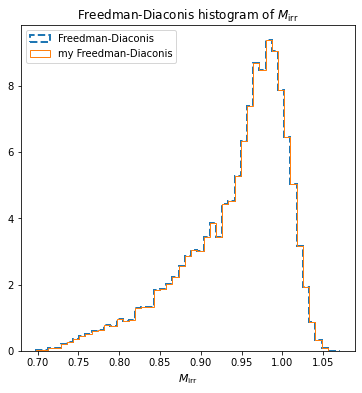

In [2]:
N_obj = 10000  
spin = np.random.uniform(0,1, size=N_obj)      #spin uniform extraction
M = norm.rvs(loc = 1, scale=0.02, size=N_obj)  #M normal extraction with mu = 1, sigma = 0.02
f = np.sqrt((1+np.sqrt(1-spin**2))/2)          #function f
M_irr = M*f                                    #irreducible mass
 
fig, ax = plt.subplots(1,1, figsize=(6,6))

#this function generates a Freedman-Diaconis histogram automatically
freedman_hist = hhist(M_irr, bins='freedman', density=True, histtype='step', label='Freedman-Diaconis', ls='--', lw=2) 

#here I try to do it by myself
sigma_G = astroMLstats.sigmaG(M_irr)         #sigma_G of M_irr
freed_width = 2/0.7413*sigma_G/N_obj**(1/3)  #bin width from Freedman rule
bins = np.arange(np.min(M_irr), np.max(M_irr), freed_width) #generating the vector with bins limits 
bins = np.append(bins, bins[-1] + freed_width) #adding the last bin

ax.hist(M_irr, bins=bins, density = True, histtype='step', label='my Freedman-Diaconis')

ax.legend(loc ='upper left')
ax.set_title('Freedman-Diaconis histogram of $M_{\mathrm{irr}}$', fontsize=12)
ax.set_xlabel('$M_{\mathrm{irr}}$', fontsize=11)

3. Using the same samples, plot the $M_{\rm irr}$ using a KDE.

To get a function from a histogram we can use the Kernel Density Estimation (KDE) technique. With this technique every single data is interpreted as a function with a given width and not like a delta function as we would usually do for a histogram.

Here I try with different functions like a 'tophat' (which is a sort of step function), gaussian, linear and epanechikov.

8.858669801468617 8.800547585670369 8.891140428583542


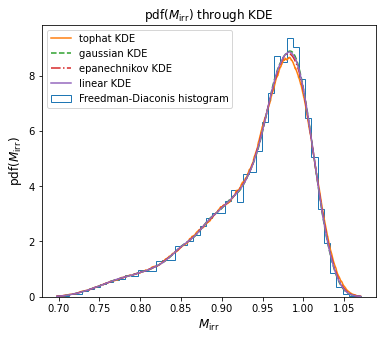

In [3]:
from sklearn.neighbors import KernelDensity

fig, ax = plt.subplots(1,1, figsize=(6,5))
x_grid = np.linspace(np.min(M_irr), np.max(M_irr), 1000)


def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

PDF_Mirr_tophat = kde_sklearn(M_irr,bandwidth=0.020,kernel="tophat")       #tophat KDE
PDF_Mirr_gauss  = kde_sklearn(M_irr,bandwidth=0.008,kernel="gaussian")     #gaussian KDE
PDF_Mirr_epan   = kde_sklearn(M_irr,bandwidth=0.021,kernel="epanechnikov") #epanechnikov KDE
PDF_Mirr_linear = kde_sklearn(M_irr,bandwidth=0.021,kernel="linear")       #linear KDE

freedman_hist = hhist(M_irr, bins='freedman', density=True, histtype='step', label='Freedman-Diaconis histogram')

#plotting
ax.plot(x_grid, PDF_Mirr_tophat, label = 'tophat KDE') 
ax.plot(x_grid, PDF_Mirr_gauss, label = 'gaussian KDE', ls='--')
ax.plot(x_grid, PDF_Mirr_epan, label = 'epanechnikov KDE', ls='-.')
ax.plot(x_grid, PDF_Mirr_linear, label='linear KDE', ls= '-')
ax.legend()
ax.set_xlabel('$M_{\mathrm{irr}}$', fontsize = 12)
ax.set_ylabel('pdf($M_{\mathrm{irr}}$)', fontsize=12)
ax.set_title('pdf($M_{\mathrm{irr}}$) through KDE')

print(np.max(PDF_Mirr_linear), np.max(PDF_Mirr_epan), np.max(PDF_Mirr_gauss))

In general increasing the bandwidth value one can notice how the generated KDE function results smoother even if it gradually disentangles from the histogram bars. In the plot above the values of the bandwidths are chosen by imposing a similar smothness in the left tail of the function. We can see that in general the tophat distribution seems the worst one to describe data in the surrounding of the peak, while linear, gausian and epanechnikov distribution seem to be the best ones.

But! Instead of deciding which function and which bandwidth are the best in this old-fashioned way, we can run a cross validation to let data decide for themselves!

In [4]:
#THIS TAKES A LOT! PLEASE DON'T RUN IT
from sklearn.model_selection import GridSearchCV

band_range = np.linspace(0.001, 0.05, 50)
grid = GridSearchCV(KernelDensity(), {'bandwidth':band_range, 'kernel':['gaussian', 'epanechnikov', 'linear']}, cv=5)
grid.fit(M_irr[:,None])
best_bw = grid.best_params_['bandwidth']
best_fu = grid.best_params_['kernel']



C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


0.014000000000000002 epanechnikov


Text(0.5, 1.0, 'pdf($M_{\\mathrm{irr}}$) with CV')

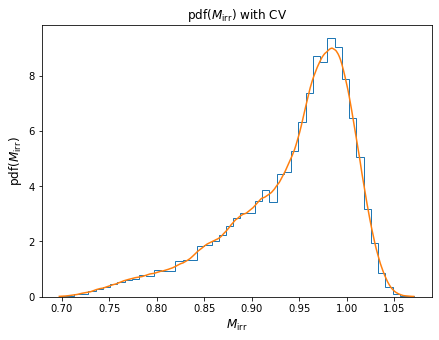

In [24]:
print(best_bw, best_fu)

fig, ax = plt.subplots(1,1, figsize=(7,5))

freedman_hist = hhist(M_irr, bins='freedman', density=True, histtype='step', label='Freedman-Diaconis histogram')

PDF_Mirr_opt  = kde_sklearn(M_irr,bandwidth=best_bw,kernel=best_fu)     #optimal_KDE
ax.plot(x_grid, PDF_Mirr_opt, label = 'gaussian KDE', ls='-')
ax.set_xlabel('$M_{\mathrm{irr}}$', fontsize = 12)
ax.set_ylabel('pdf($M_{\mathrm{irr}}$)', fontsize=12)
ax.set_title('pdf($M_{\mathrm{irr}}$) with CV')

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

Now, to prove whether two variables are generated from the same distribution we can use the Kolmogorov-Smirnov (KS) test.
This test aims to find the maximum distance between the cdf of two variables to understand how likely it is that this difference is produced by data generated by the same distibution.

In the following cells I'm computing the KS test between $M_{irr}$ - $f$ and $M_{irr}$ - $M$ as a function of the $\sigma$ value of the normal distribution of M.

In [16]:
#changing the sigma
sigma=np.logspace(-6,8,60)

KS_value_Mirr_f = np.zeros(len(sigma))
KS_value_Mirr_M = np.zeros(len(sigma))
KS_prob_Mirr_f = np.zeros(len(sigma))
KS_prob_Mirr_M = np.zeros(len(sigma))

for j in range(len(sigma)): 
    spin_s = np.random.uniform(0,1, size=N_obj)
    M_s = norm.rvs(loc = 1, scale=sigma[j], size=N_obj) #re-defining M
    f_s = np.sqrt((1+np.sqrt(1-spin_s**2))/2)  
    M_irr_s = M_s*f_s
    
    KS_value_Mirr_f[j] = ks_2samp(M_irr_s, f_s)[0]      #KS distance between M_irr and f
    KS_value_Mirr_M[j] = ks_2samp(M_s, M_irr_s)[0]      #KS distance between M_irr and M
    
    KS_prob_Mirr_f[j] = ks_2samp(M_irr_s, f_s)[1]       #KS p-value between M_irr and f
    KS_prob_Mirr_M[j] = ks_2samp(M_s, M_irr_s)[1]       #KS p-value between M_irr and f

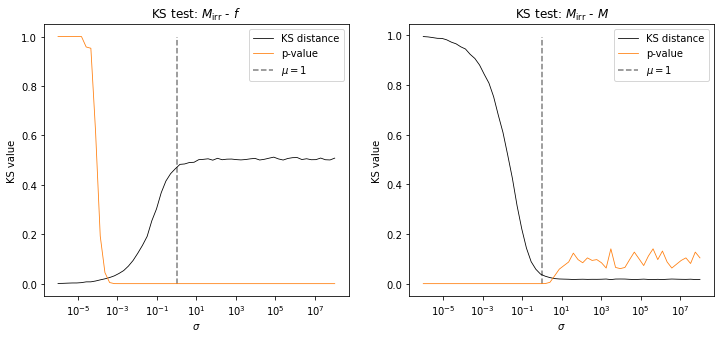

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(sigma, KS_value_Mirr_f, c='black', lw=0.8, label='KS distance')
ax[0].plot(sigma, KS_prob_Mirr_f, c='tab:orange', lw=0.8, label='p-value')
ax[0].vlines(x= 1, ymin=0, ymax=1, ls='--', color='gray', label='$\\mu = 1$')
ax[0].set_xlabel('$\\sigma$')
ax[0].set_ylabel('KS value')
ax[0].set_xscale('log')
ax[0].set_title('KS test: $M_{\mathrm{irr}}$ - $f$')
ax[0].legend()

ax[1].plot(sigma, KS_value_Mirr_M, c='black', lw=0.8, label='KS distance')
ax[1].plot(sigma, KS_prob_Mirr_M, c='tab:orange', lw=0.8, label='p-value')
ax[1].vlines(x= 1, ymin=0, ymax=np.max(KS_value_Mirr_M), ls='--', color='gray', label='$\\mu = 1$')
ax[1].set_xlabel('$\\sigma$')
ax[1].set_ylabel('KS value')
ax[1].set_title('KS test: $M_{\mathrm{irr}}$ - $M$')
ax[1].set_xscale('log')
ax[1].legend()

From the two plots above we clearly see that if $\sigma << \mu$ then $M_{irr}$ distribution if closer to that of $f$, while for $\sigma >> \mu$, $M_{irr}$ distribution is more similar to that of $M$. However this point can be proven by computing the density functions of all variables: $f$, $M$ and $M_{irr}$ for a given value of $\sigma$, in this case 0.02.

We can try to demonstrate it with a few plots.

6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.

<ipython-input-19-670a06703d4f>:14: RuntimeWarning: divide by zero encountered in true_divide
  ax[0].plot(np.linspace(0.7, 1., 100), 2*(2*np.linspace(0.7, 1, 100)**2-1)/(1-np.linspace(0.7, 1, 100)**2)**0.5, label='pdf(f)')


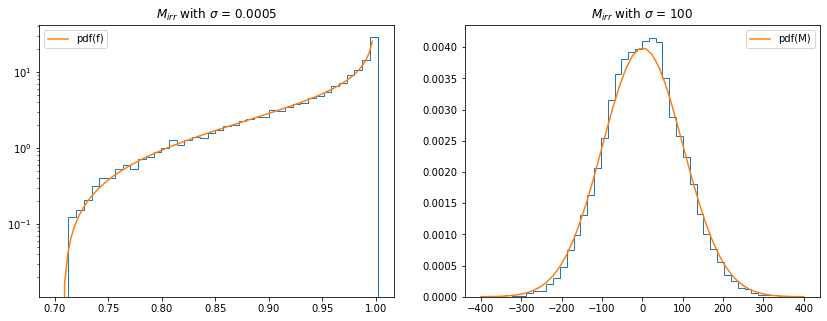

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14, 5))

spin_1 = np.random.uniform(0,1, size=N_obj)
M_1 = norm.rvs(loc = 1, scale=0.0005, size=N_obj) #re-defining M
f_1 = np.sqrt((1+np.sqrt(1-spin_1**2))/2)  
M_irr_1 = M_1*f_1

spin_2 = np.random.uniform(0,1, size=N_obj)
M_2 = norm.rvs(loc = 1, scale=100, size=N_obj) #re-defining M
f_2 = np.sqrt((1+np.sqrt(1-spin_2**2))/2)  
M_irr_2 = M_2*f_2

ax[0].hist(M_irr_1, density=True, bins=40, histtype='step')
#distributin of f found from the passages below!
ax[0].plot(np.linspace(0.7, 1., 100), 2*(2*np.linspace(0.7, 1, 100)**2-1)/(1-np.linspace(0.7, 1, 100)**2)**0.5, label='pdf(f)')
ax[0].set_title('$M_{irr}$ with $\sigma$ = 0.0005')
ax[0].legend(loc='upper left')
ax[0].set_yscale('log')


ax[1].hist(M_irr_2, density=True, bins=40, histtype='step')
ax[1].plot(np.linspace(-400, 400, 50), norm(loc = 1, scale=100).pdf(np.linspace(-400, 400, 50)), label='pdf(M)')
ax[1].set_title('$M_{irr}$ with $\sigma$ = 100')
ax[1].legend()

7. (At home...)  Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint 1*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

*Hint 2*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If yes please tell me!)
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}


Analitically we can find the pdf($f$) from the formula:

$$ \mathrm{pdf}(f) = |\frac{df}{d\chi}|^{-1} \mathrm{pdf}({\chi}) $$

Since the distribution of $\chi$ is uniform between 0 and 1 then: $\mathrm{pdf}(\chi) = 1$.

And from the definition of $f$ we find:

$$ \mathrm{pdf}(f) = 2\frac{2f^2-1}{\sqrt{1-f^2}} $$

(all the passages are displayed at the end of the document).

Text(0.5, 1.0, '$f$ distribution function')

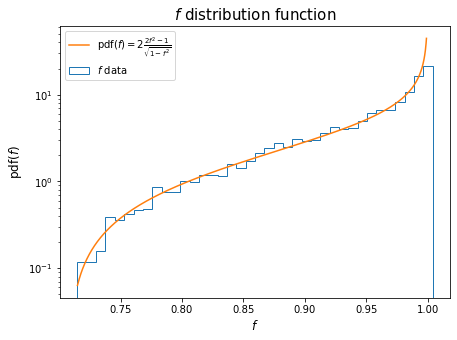

In [20]:
#cheking the f distibution
fig, ax = plt.subplots(1,1, figsize=(7,5))

x_f = np.linspace(np.min(f), 0.999, 1000)
f_freed = hhist(f, bins='freedman', density=True, histtype='step', label='$f$ data') #freedman histogram for f data

def pdf_f(f):
    return 2*(2*f**2-1)/(1-f**2)**0.5    #pdf(f) as found analytically

ax.plot(x_f, pdf_f(x_f), label = '$\mathrm{pdf}(f) = 2\\frac{2f^2-1}{\\sqrt{1-f^2}}$')
ax.legend()

ax.set_yscale('log')
ax.set_xlabel('$f$', fontsize=12)
ax.set_ylabel('pdf($f$)', fontsize=12)
ax.set_title('$f$ distribution function', fontsize=15)

Then, to find the pdf($M_{irr}$) we use the theorem that states that if we have a product of two independent variables, so that: $Z = XY$, with $f_{X}$ and $f_{Y}$ being the pdf of $X$ and $Y$ respectively, then the probability density function of $Z$ is:

$$\mathrm{pdf}(z) = \int_{-\infty}^{\infty}f_{X}(x)f_{Y}(z/x)\frac{1}{|x|}dx$$.

In our case:

$$\mathrm{pdf}(f) = 2 \frac{2f^2-1}{\sqrt{1-f^2}}$$  

for $f$ that goes from $1/\sqrt{2}$ to $1$. And:

$$\mathrm{pdf}(M) = \frac{1}{\sqrt{2 \pi} \sigma} \exp{-\frac{(M-\mu)^2}{2\sigma^2} }$$

Therefore:

$$\mathrm{pdf}(M_{irr}) = \sqrt{\frac{2}{\pi}}\frac{1}{\sigma} \int_{\frac{1}{\sqrt{2}}}^{1}\frac{2f^2-1}{f \sqrt{1-f^2}} \exp{\left(-\frac{(M_{irr}/f - \mu)^2}{2\sigma^2}\right)}df$$

Text(0.5, 0, 'M$_{irr}$')

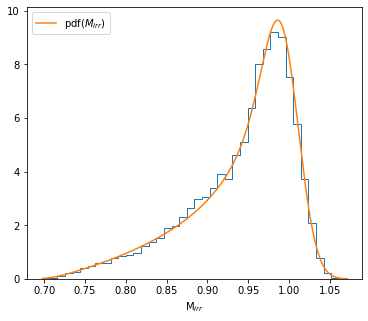

In [26]:
def int_func(x, M_irr, mu, sigma):
    return np.exp(-(M_irr/x - mu)**2/(2*sigma**2))* (2*x**2-1)/(x*(1-x**2)**0.5)  #integrand function

integral = np.zeros(len(x_grid))
M_irr_pdf= np.zeros(len(x_grid))

for i in range(len(x_grid)):
    integral[i] = integrate.quad(int_func, 1/np.sqrt(2), 1, args = (x_grid[i], 1, 0.02))[0] #integral
    M_irr_pdf[i]= np.sqrt(2/np.pi)/0.02*integral[i] #M_irr pdf

fig, ax = plt.subplots(1,1, figsize=(6,5))

ax.hist(M_irr, density=True, histtype='step', bins=40)
ax.plot(x_grid, M_irr_pdf, label='pdf($M_{irr}$)')
ax.legend(loc='upper left')
ax.set_xlabel('M$_{irr}$')

Text(0.5, 0, 'M$_{irr}$')

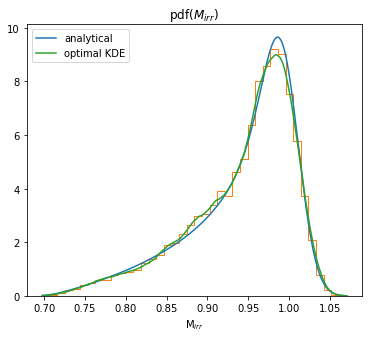

In [27]:
#comparing the pdf(M_irr) found analytically with the KDE distribution
fig, ax = plt.subplots(1,1, figsize=(6,5))

ax.plot(x_grid, M_irr_pdf, label='analytical')
ax.hist(M_irr, histtype='step', density=True, bins=40)
ax.plot(x_grid, PDF_Mirr_opt, label='optimal KDE')

ax.set_title('pdf($M_{irr}$)')
ax.legend()
ax.set_xlabel('M$_{irr}$')

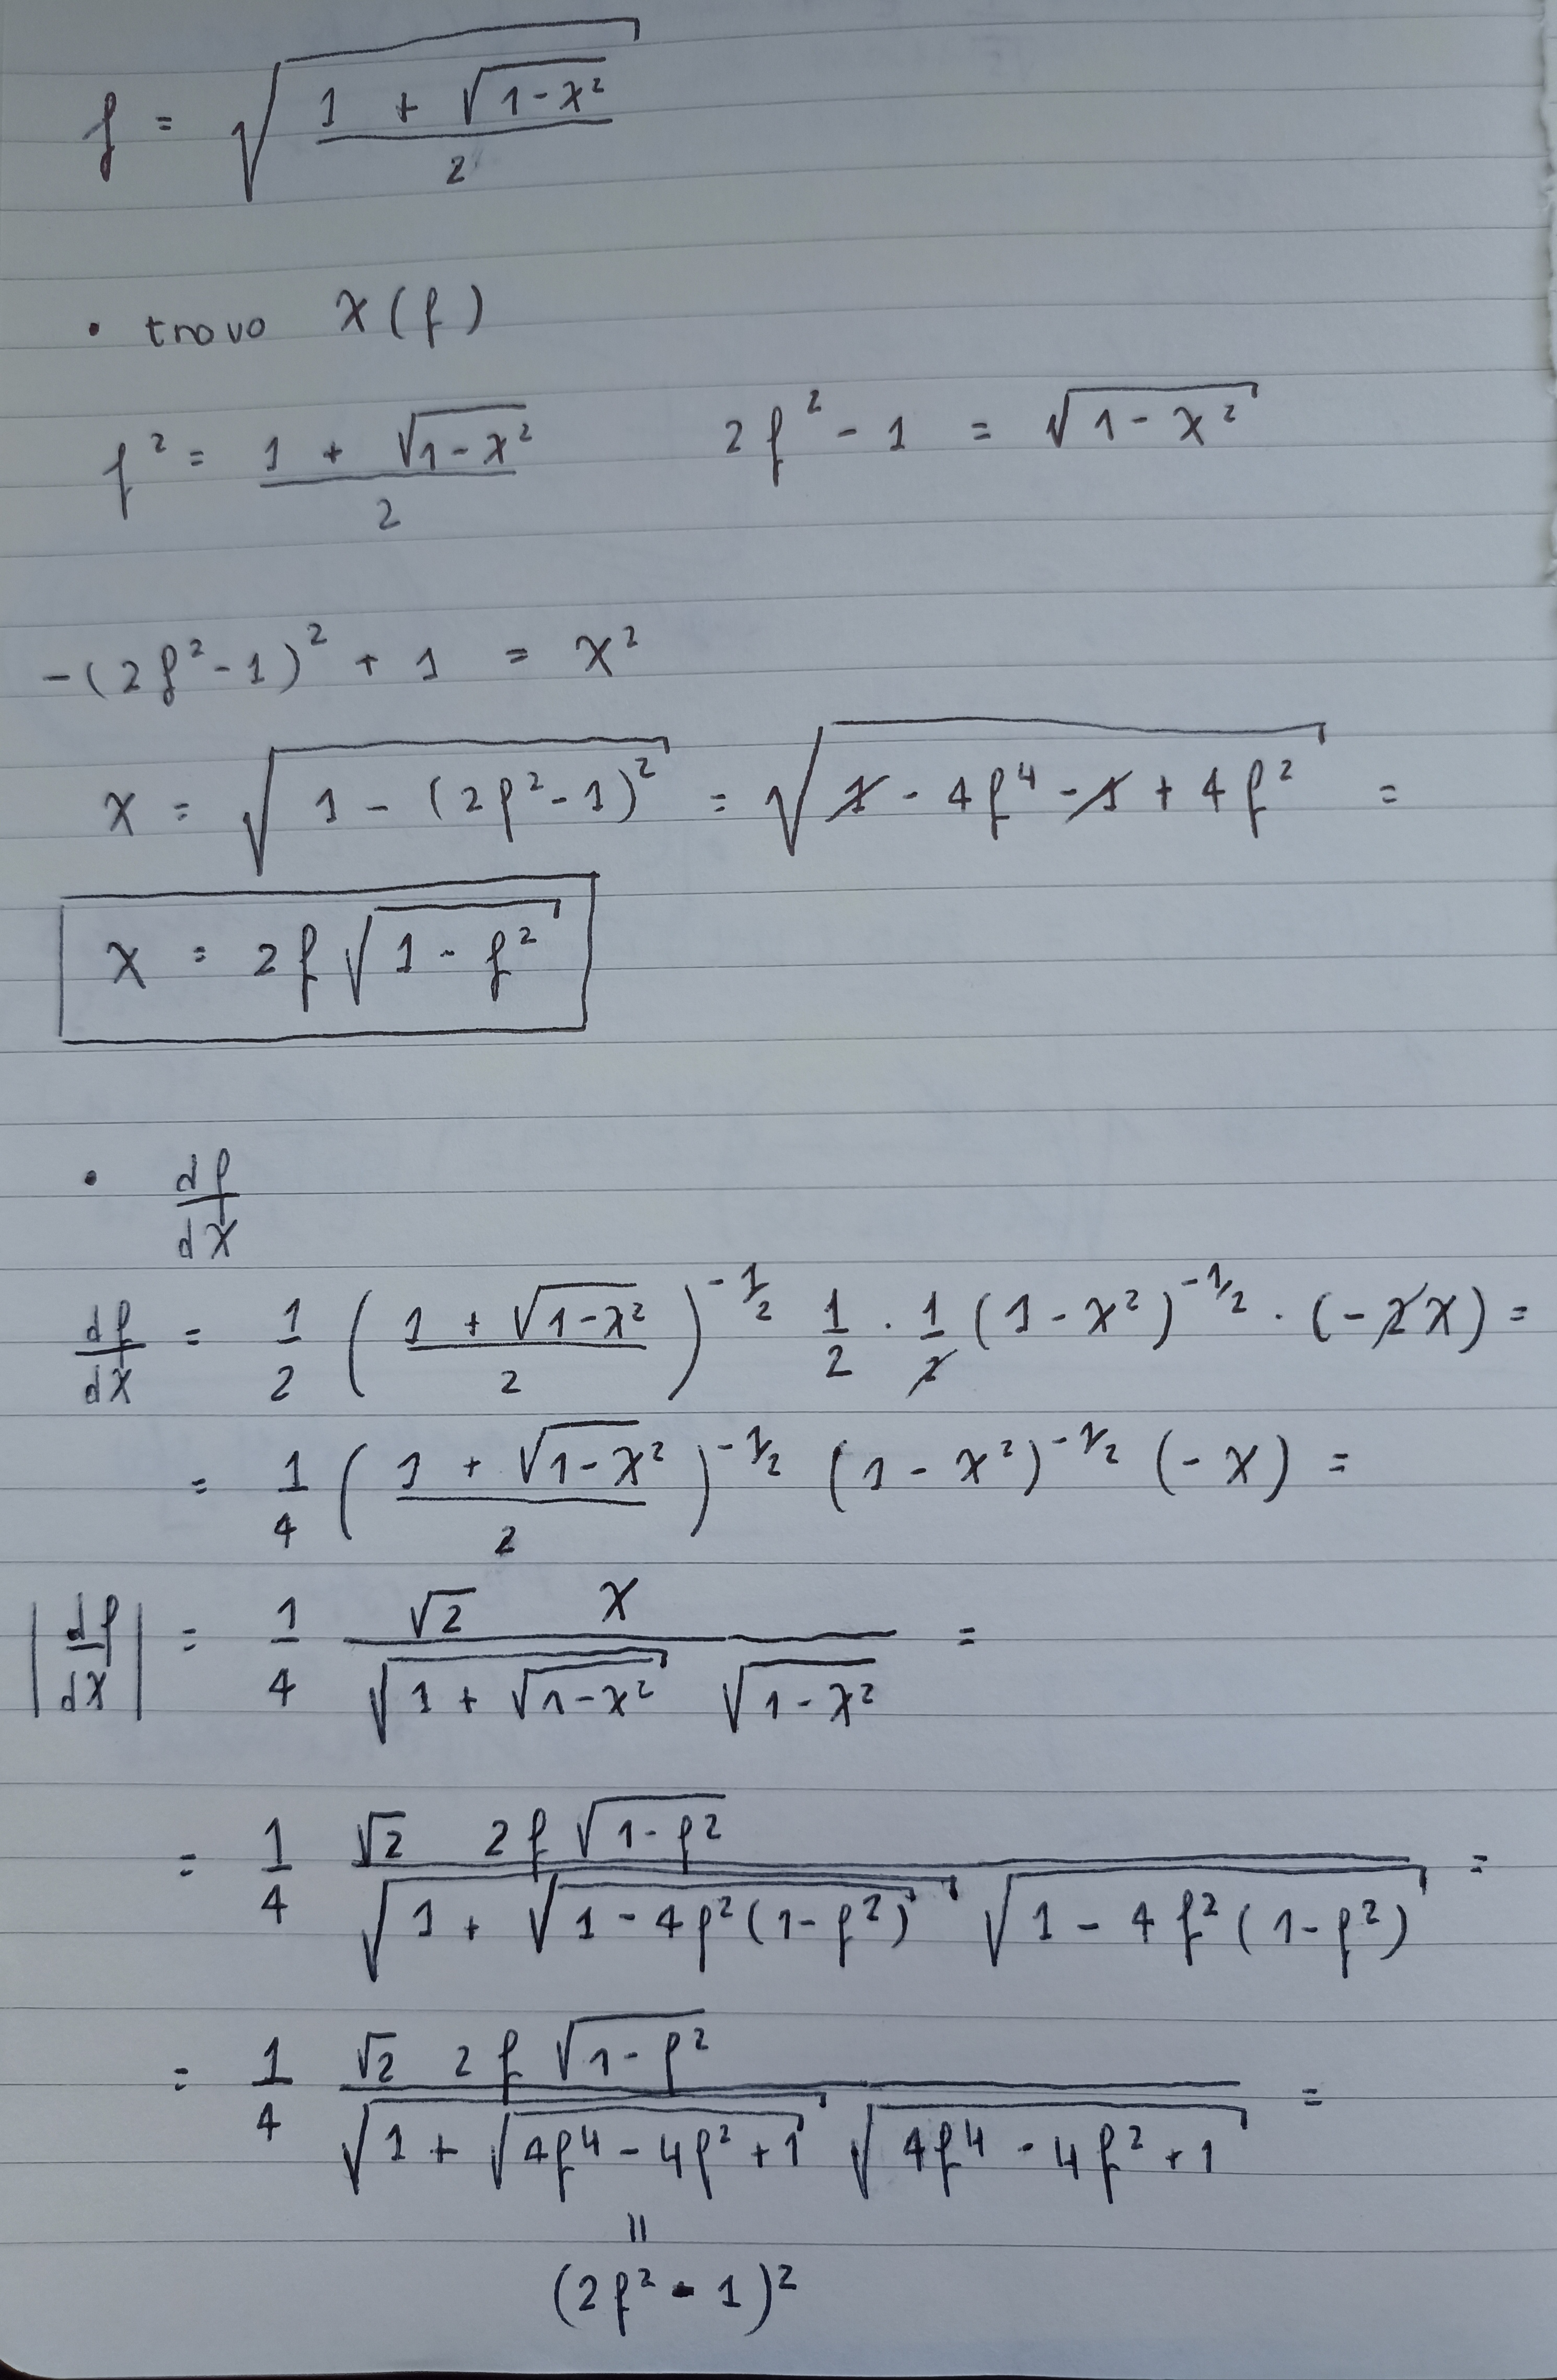

In [12]:
from IPython.display import Image
Image('f_dist1.jpg')

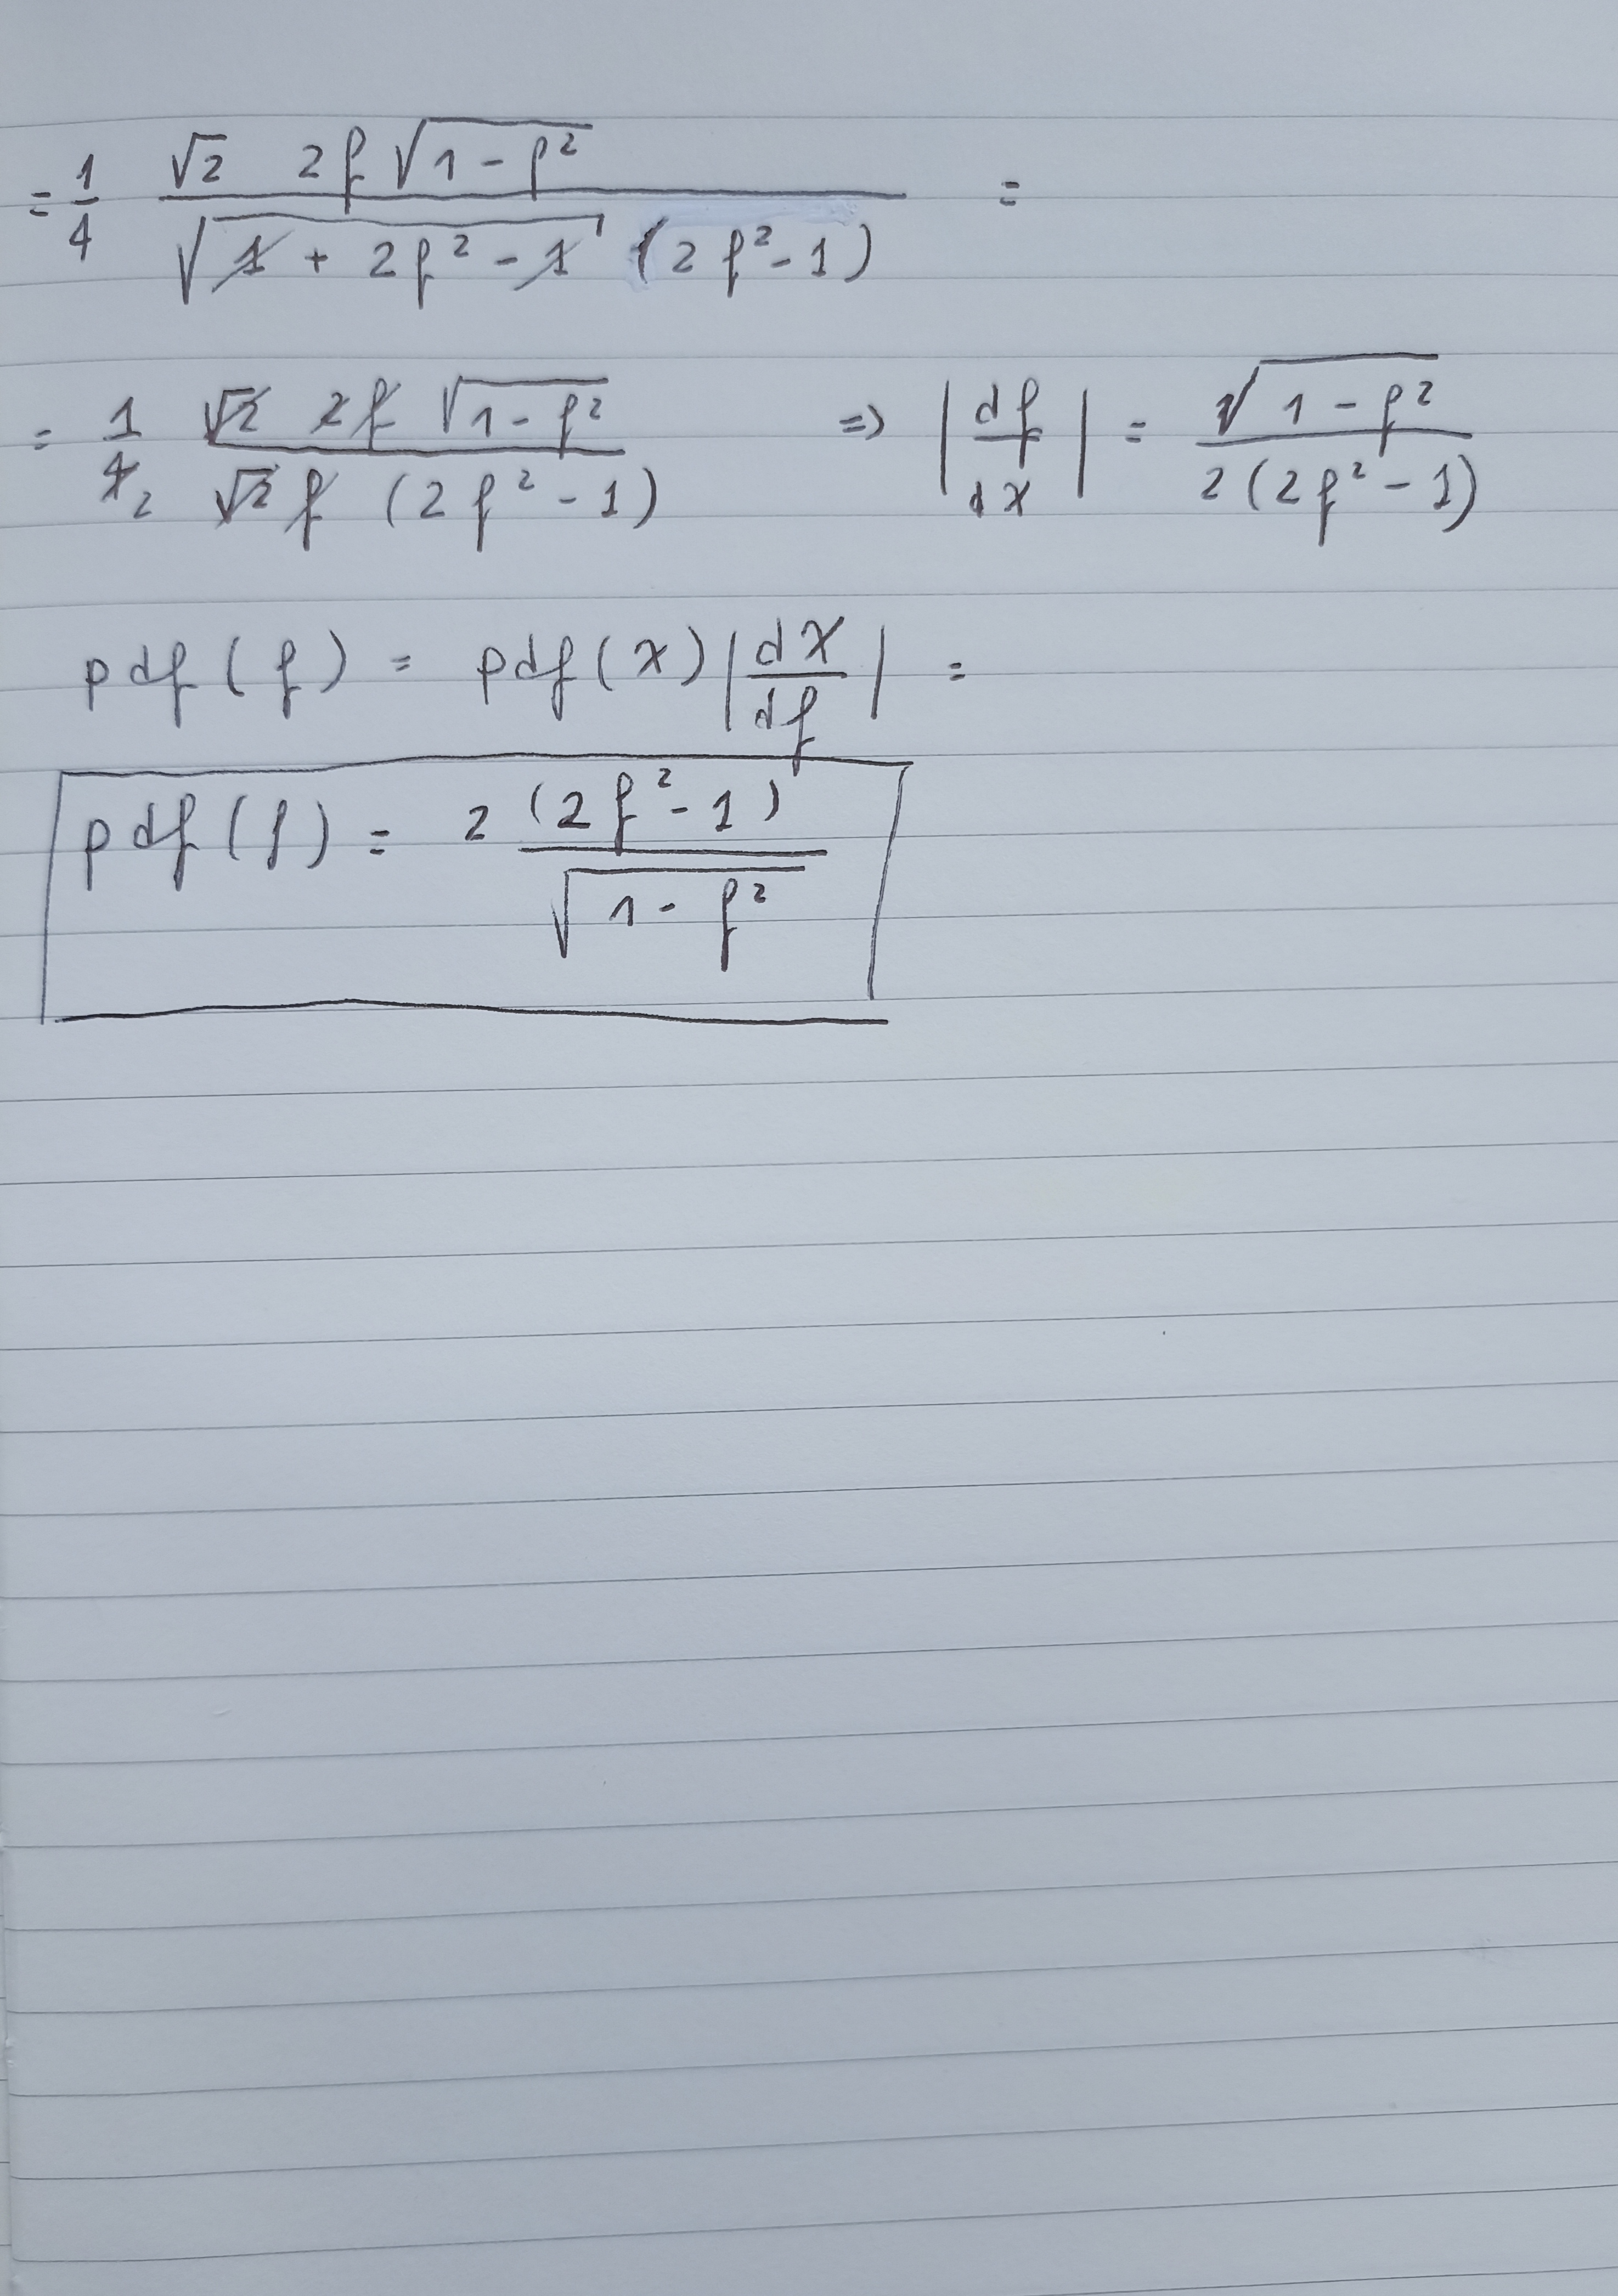

In [13]:
Image('f_dist2.jpg')